Fichier JSON (avec 5 labels: Interieur/exterieur, ...)

But: Faire une étude de faisabilité pour detecter les 5 labels automatiquement
Contrainte: Pas d'entrainement ==> Utiliser plutot le feature engineering d'images

2 techniques:
    Classique: voir [Webinaire](https://app.livestorm.co/openclassrooms-1/pretraitement-dimages-detecter-automatiquement-la-meteo?type=detailed)
       1. SIFT (ou ORB): Permet de determiner les descripteurs (Algo pour trouver les Feature Engineering) 
       2. T-SNE : Decomposition en 2D, pour visualiser la seprataion des labels 
       3. k_Means pour mesurer ARI
    Reseaux de Neurones  : 
       1. Feature Engineering (CNN Transfer Learning)
       2. T-SNE : Decomposition en 2D, pour visualiser la seprataion des labels 
       3. k_Means pour mesurer ARI

Attention à l'equilibrage des classes pour chaque Label


!!! SIFT Version penSource = 3.4

Concept Numero 1 : SIFT

    Points clés = Points remarquable : Sont décrits par les descripteurs
    Comment utiliser les descripteurs, pour créer des feature par image

Concept Numero 2: Bag of Visual words

    Regroupement des descripteurs par clusters (kMeans)
    L'idée est de rapprocher les descripteurs entre eux. Utiliser les hostogrammes pour compter les descripteurs par Cluster
    
Etapes:
1. Créer descripteurs
2. Créer clusters de descipteurs (MiniBatchkMeans)
3. Créer Histogramme par image
4. Reduction dimension (PCA / T-SNE)
5. Analyse visuelle: Affichage T-SNE selon catégories
6. Analyse de similarité



In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

import seaborn as sns
%matplotlib inline

#import plotly as plty
#import plotly.express as px

import os
from os import listdir, path
from os.path import isfile, join, splitext

import tarfile
import json
import csv
import random
import collections
from collections import Counter, OrderedDict

import warnings
warnings.filterwarnings('ignore')

import time
import cv2

from sklearn import cluster, metrics, preprocessing, manifold, decomposition
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics.cluster import adjusted_rand_score


from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


from PIL import Image
from PIL import ImageFilter
from PIL import ImageOps

#### Fonctions
On va créer une fonction de preprocessing qui va appliquer à une image chargée, un débruitage optionnel et égaliser l'exposition avec l'égalisateur CLAHE :
- Débruiter : Flou Gaussien ([Source](https://docs.opencv.org/4.5.1/d4/d13/tutorial_py_filtering.html))
- Egalisation des histogrammes (exposition) : CLAHE ([Source](https://docs.opencv.org/4.5.1/d5/daf/tutorial_py_histogram_equalization.html))

In [10]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

#fonction de preprocessing
def preprocess(image, colors = 'BlackandWhite', resize = False, equalize = 'Hist', blur = None, ksize = (1, 1)):
    image = cv2.imread(image) # convert in gray
    
    if (colors == 'BlackandWhite'):
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)   # Convert color image  
    elif (colors == 'HSV'):
        image = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)   # Convert color image
    
    if (resize == True):
        image = cv2.resize(image,(224,224))   # resize image
    
    if (equalize == 'hist'):
        image = cv2.equalizeHist(image)   # equalize image histogram
    elif (equalize == 'clahe'): # equalize image histogram
        image = clahe.apply(image)
    
    if (blur == 'Gaussian'):
        image = cv2.GaussianBlur(image,ksize,0) #Debruitage ou Lissage 
    elif (blur == 'Normal'): 
        image = cv2.blur(image, ksize) #Debruitage ou Lissage
    
    return image

In [11]:
def create_lists(data: pd.DataFrame):
    list_inside=[data['image_full_name'][i] for i in range(len(data)) if data["label"][i]=="inside"]
    list_outside=[data['image_full_name'][i] for i in range(len(data)) if data["label"][i]=="outside"]
    list_drink=[data['image_full_name'][i]for i in range(len(data)) if data["label"][i]=="drink"]
    list_food=[data['image_full_name'][i] for i in range(len(data)) if data["label"][i]=="food"]
    list_menu=[data['image_full_name'][i] for i in range(len(data)) if data["label"][i]=="menu"]
    return (list_inside, list_outside, list_drink, list_food, list_menu)



In [12]:
#Function to plot PIE Chart of n tops values in dataframe
def plot_ntops_pie(data: pd.DataFrame, colunm_name, ntops: int, plot_others: bool, plot_na: bool):
    podium_tops = pd.DataFrame(data[colunm_name].value_counts(dropna=True, sort=True).head(ntops))
    if (plot_others == True):
        remainings_counts = sum(data[colunm_name].value_counts(dropna=True)[ntops:])
        remainings_below = pd.DataFrame({colunm_name : [remainings_counts]}, index=['others'])
        podium_tops = pd.concat([podium_tops, remainings_below], ignore_index = None, axis = 0)
    if (plot_na == True):
        na_counts = data[colunm_name].isna().sum()
        remainings_na = pd.DataFrame({colunm_name : [na_counts]}, index=['NAN'])
        podium_tops = pd.concat([podium_tops, remainings_na], ignore_index = None, axis = 0)
    
    #Définir la taille du graphique
    plt.figure(figsize=(8,8))
    #Définir lae type du graphique, ici PIE CHart avec en Labels l'index du nom des libelle
    #l'autopct sert ici à afficher le % calculé avec 1 décimal derriere la virgule
    plt.pie(podium_tops[colunm_name], labels=podium_tops.index, autopct='%1.1f%%')
    #Afficher la légende en dessous du graphique au centre
    plt.legend(loc='upper left', bbox_to_anchor=(0.1, -0.01), fancybox=True, shadow=None, ncol=2)
    plt.title(f"{ntops} most presents values identified in column {colunm_name} .\nTOTAL unique = {len(data[colunm_name].unique())}")
    #Afficher le graphique
    plt.show()
    return(podium_tops)

## Etude du dataset
### Accès aux photos

In [13]:
dataset_global_dir = 'C:/Users/blanc/OpenClassrooms/IA_Project6_Openclassrooms_IAstart-up/dataset'

In [14]:
path_photos = (dataset_global_dir+"/photos")
photos_full_name = []
photos_name = []
photos_ext = []
photos_size = []


# List all files in a directory using os.listdir
for entry in os.listdir(path_photos):
    if os.path.isfile(os.path.join(path_photos, entry)):
        photos_full_name.append(entry)
        photos_name.append(splitext(entry)[0])
        photos_ext.append(splitext(entry)[1])
        photos_size.append(os.stat(os.path.join(path_photos, entry)).st_size)
        

print(len(photos_full_name))
print(len(photos_name))
print(len(photos_ext))
print(len(photos_size))

200098
200098
200098
200098


In [15]:
data = pd.DataFrame()
data["image_full_name"] = photos_full_name
data["image_name"] = photos_name
data["image_ext"] = photos_ext
data["size"] = photos_size

data["path"] = (path_photos+'/')

data.head()

image_full_name              image_name image_ext   size  \
0  --0h6FMC0V8aMtKQylojEg.jpg  --0h6FMC0V8aMtKQylojEg      .jpg  35221   
1  --3JQ4MlO-jHT9xbo7liug.jpg  --3JQ4MlO-jHT9xbo7liug      .jpg  36060   
2  --3P3fjPrScy06XVLi4vhg.jpg  --3P3fjPrScy06XVLi4vhg      .jpg  63046   
3  --4DfhW2sJvjeC90KEDX3g.jpg  --4DfhW2sJvjeC90KEDX3g      .jpg  26804   
4  --5V3mRlhb3zqE5yF4Gpaw.jpg  --5V3mRlhb3zqE5yF4Gpaw      .jpg  36058   

                                                path  
0  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...  
1  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...  
2  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...  
3  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...  
4  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...

### Fichier JSON associé aux photos

In [16]:
#Definir le nombre de lignes à importer depuis le fichier JSON
n = len(photos_name)

In [17]:
images = []
with open((dataset_global_dir+"/yelp_academic_dataset_photos.json"), encoding="utf8") as fl:
    for i, line in enumerate(fl):
        images.append(json.loads(line))
        if i+1 >= n:
            break
images_json_df = pd.DataFrame(images)
print(images_json_df.shape)

(200098, 4)


### Assemblage des données JSON et des fichiers photos

In [18]:
images_df = pd.merge(images_json_df, data, how='left', left_on=['photo_id'], right_on=['image_name'])
images_df.head(3)

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   

                                             caption    label  \
0  Nice rock artwork everywhere and craploads of ...   inside   
1                                                     outside   
2                                     oyster shooter    drink   

              image_full_name              image_name image_ext   size  \
0  zsvj7vloL4L5jhYyPIuVwg.jpg  zsvj7vloL4L5jhYyPIuVwg      .jpg  22110   
1  HCUdRJHHm_e0OCTlZetGLg.jpg  HCUdRJHHm_e0OCTlZetGLg      .jpg  57858   
2  vkr8T0scuJmGVvN2HJelEA.jpg  vkr8T0scuJmGVvN2HJelEA      .jpg  40485   

                                                path  
0  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...  
1  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...  
2  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...

### Encodage du label

In [19]:
le = preprocessing.LabelEncoder()
images_df["label_encoded"] = le.fit_transform(images_df["label"])
images_df.sort_values(by=['size'])

photo_id             business_id  \
48681   qMlGILrsrzhMDxajNYiyIA  -gV5HzOUDyWirA15UeffCg   
119072  QRUo4vqUu3X9V4eIqBpY8A  AKaE3d2sX-BoWWmski0w_Q   
101495  zTzdu2QqLozHpW_qYWF84w  f4aCur7Vrf9F8YUAOFFWiA   
65262   JoQ5xekjQUkj8rukJIzqgg  jFgbX3aCOgtKba6FkxQymg   
119033  IUsKp87a-v9Yhx6Ftg1m5A  dBa7aJXV50TZEtInwdbvfg   
...                        ...                     ...   
126366  w10rnii7GNkQo7kifHjBEQ  ppZh21qnYn9etrERwBeASA   
156585  RRur2l6R6wgsF14hXkgm9g  zvcyW3ZtPYWziX7k9tCFBg   
194624  jl2aS-D8AqMlrzYDXnQ2Wg  JZwWXlBq_sfrn_CuBcojhw   
44638   twpKQbvG1fIyl8PT1V-_9g  3AjwyeF8oiTiHij9vFgyMw   
45139   tsbd43r8KPHukelzyAd5EQ  z1TyupB3dqGlAfijPyGryA   

                                                  caption    label  \
48681                                                         food   
119072                                                        food   
101495                                                        food   
65262                                                         food   
119033                                                        food   
...                                                   ...      ...   
126366                                                        food   
156585  Enjoy the taste of family meals at Bo Fung Chi...     food   
194624                                                      inside   
44638              Grilled Veggies from our catering Menu     food   
45139                                                      outside   

                   image_full_name              image_name image_ext    size  \
48681   qMlGILrsrzhMDxajNYiyIA.jpg  qMlGILrsrzhMDxajNYiyIA      .jpg     243   
119072  QRUo4vqUu3X9V4eIqBpY8A.jpg  QRUo4vqUu3X9V4eIqBpY8A      .jpg     243   
101495  zTzdu2QqLozHpW_qYWF84w.jpg  zTzdu2QqLozHpW_qYWF84w      .jpg     243   
65262   JoQ5xekjQUkj8rukJIzqgg.jpg  JoQ5xekjQUkj8rukJIzqgg      .jpg     243   
119033  IUsKp87a-v9Yhx6Ftg1m5A.jpg  IUsKp87a-v9Yhx6Ftg1m5A      .jpg     243   
...                            ...                     ...       ...     ...   
126366  w10rnii7GNkQo7kifHjBEQ.jpg  w10rnii7GNkQo7kifHjBEQ      .jpg  450474   
156585  RRur2l6R6wgsF14hXkgm9g.jpg  RRur2l6R6wgsF14hXkgm9g      .jpg  452796   
194624  jl2aS-D8AqMlrzYDXnQ2Wg.jpg  jl2aS-D8AqMlrzYDXnQ2Wg      .jpg  463081   
44638   twpKQbvG1fIyl8PT1V-_9g.jpg  twpKQbvG1fIyl8PT1V-_9g      .jpg  465110   
45139   tsbd43r8KPHukelzyAd5EQ.jpg  tsbd43r8KPHukelzyAd5EQ      .jpg  505686   

                                                     path  label_encoded  
48681   C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              1  
119072  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              1  
101495  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              1  
65262   C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              1  
119033  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              1  
...                                                   ...            ...  
126366  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              1  
156585  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              1  
194624  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              2  
44638   C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              1  
45139   C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4  

[200098 rows x 10 columns]

In [20]:
filename_csv = './dataset/images_df.csv'
images_df.to_csv(filename_csv, encoding='utf-8', index=False)
print(f'Images dataframe {filename_csv} is stored in CSV format')

Images dataframe ./dataset/images_df.csv is stored in CSV format


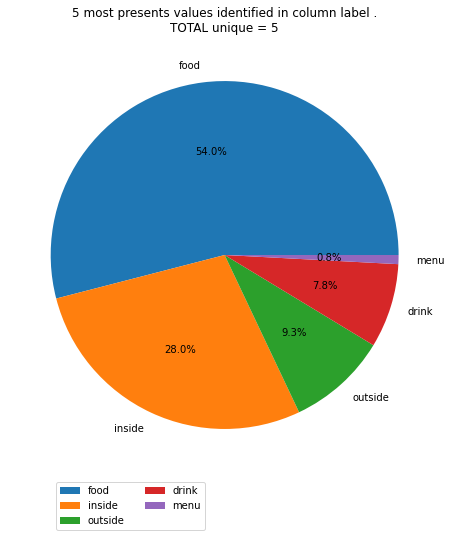

label
food     108046
inside    56030
outside   18569
drink     15669
menu       1678

In [21]:
#plot_ntops_pie(images_df, 'label', 5, False, False)
unacceptable_image = images_df['size'].min()
plot_ntops_pie(images_df.loc[(images_df['size'] > unacceptable_image),:], 'label', 5, False, False)

Nous notons ici qu'une forte proportion des données sont associées au label = food.
A ce titre, nous serons vigileant afin de bien utiliser cette repartition du fichier d'entrée.

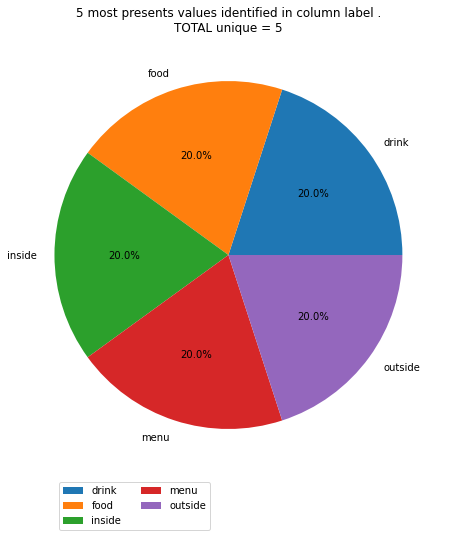

label
drink     1000
food      1000
inside    1000
menu      1000
outside   1000

In [22]:
n_sample = 1000
#weighted_images_df = images_df.groupby("label").sample(n=n_sample, random_state=1).reset_index(drop = True)

weighted_images_df = images_df.loc[(images_df['size'] > unacceptable_image),:].groupby("label").sample(n=n_sample, random_state=0).reset_index(drop = True)
plot_ntops_pie(weighted_images_df, 'label', 5, False, False)

#weighted_images_df["label_encoded"] = le.fit_transform(weighted_images_df["label"])

Nous observons ici que 5 valeurs sont indiquées, et devraient permettre de classer les photos.
    
    inside
    outside
    drink
    food
    menu
    
Nous allons visualiser certaines de ces photos, pour comprendre si un lien peut etre facilement établi entre Label et Photo.

## Affichage de quelques photos
Nous souhaitons ici afficher quelques photos associées à chacun des label

In [23]:
list_labels = weighted_images_df['label'].unique()
list_labels

array(['drink', 'food', 'inside', 'menu', 'outside'], dtype=object)

In [24]:
images = []
def list_fct(data: pd.DataFrame, name) :
    #list_image_name = [photos_full_name[i] for i in range(len(images_df)) if images_df["label"][i]==name]
    list_image_name = [data['image_full_name'][i] for i in range(len(data)) if data["label"][i]==name]
    return (list_image_name)


In [25]:
list_inside, list_outside, list_drink, list_food, list_menu = create_lists(weighted_images_df)

drink


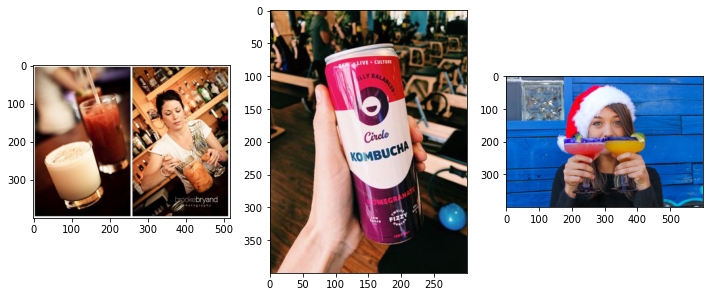

food


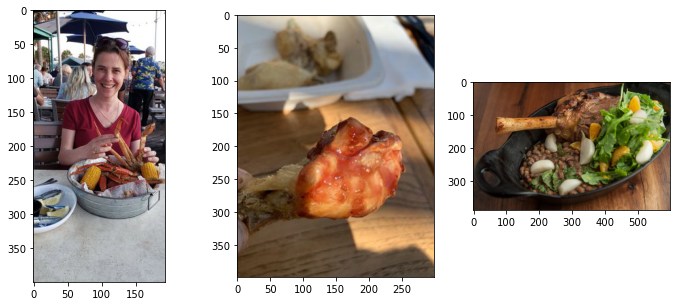

inside


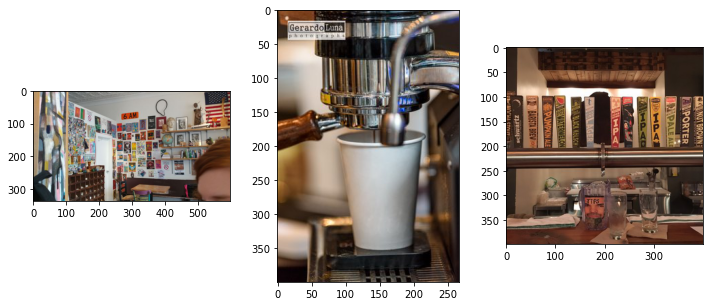

menu


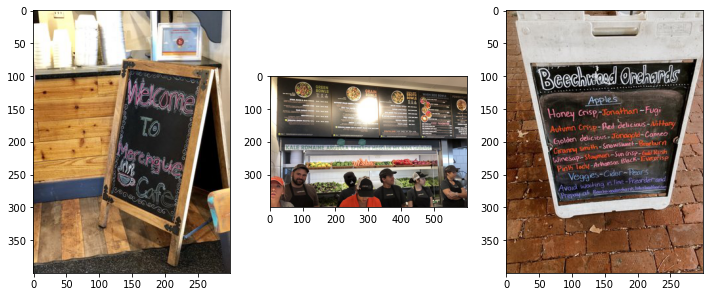

outside


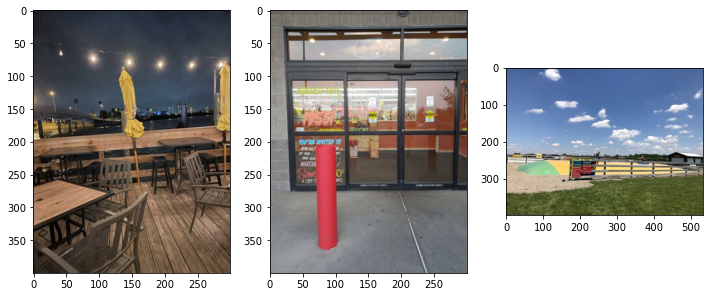

In [26]:
path = (path_photos+'/')

for name in list_labels :
    print(name)
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(weighted_images_df, name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

Au regard des quelques photos tirées de chacun de ces labels, nous reconnaissons les classes/label de façon distinctes.
Nous pourrons donc utiliser cette information à des fins d'entrainement. 

En revanche, nous allons réaliser au préalable une étude de faisabilité pour detecter ces 5 labels automatiquement, sur la base de feature engineering.


## Manipulation des photos
### Génération et étude d'histogrammes

Nous représentons la repartition des pixels selon leur intensité : Pour une image en noir et blanc, il indique en abscisse le niveau de gris (entier entre 0 et 255) et en ordonnée, le nombre de pixels ayant cette valeur.

La génération d'histogrammes se fait aisément en Python avec la fonction  hist  de matplotlib.pyplot.

[Voir Cours OC](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5024566-appliquez-vos-premiers-traitements-dimages#/id/r-6319125)

drink


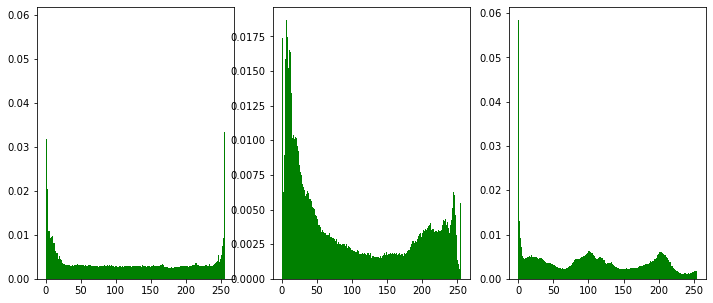

food


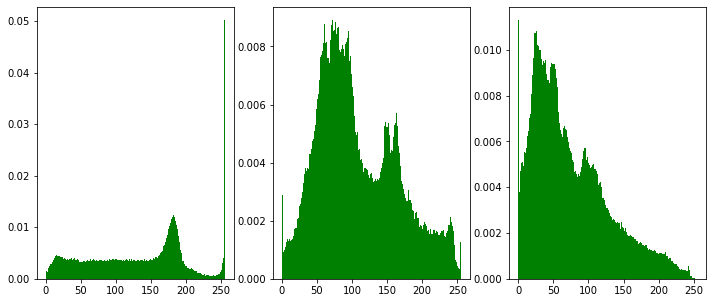

inside


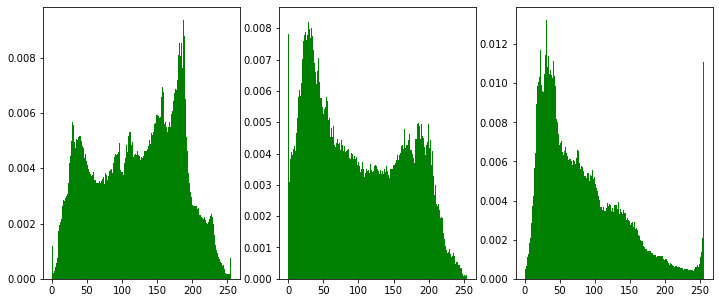

menu


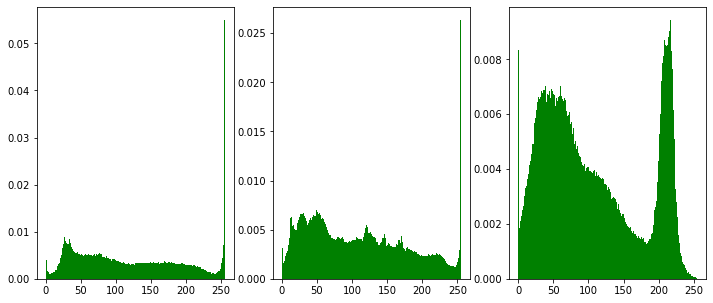

outside


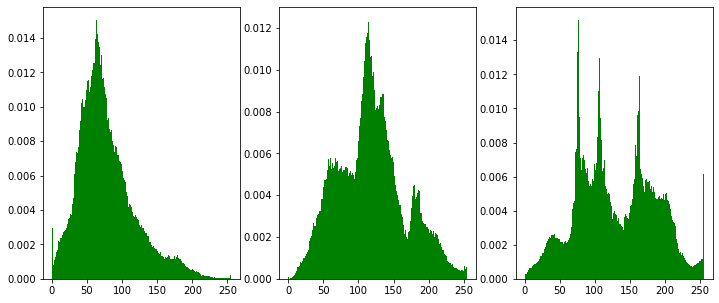

In [27]:
path = (path_photos+'/')
colors = None #Other options = None, 'BlackandWhite', HSV
resize = None #False
equalize = None #Other options: None, 'Hist', 'Clahe'
blur = None #Other options: None, 'Normal' ou 'Gaussian'
ksize = (5, 5) # ksize

for name in list_labels :
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)
    print(name)
    # print("-------")
    for i in range(3):
        #plt.subplot(4, 3, i)
        plt.subplot(130 + i + 1)
        filename = path + list_fct(weighted_images_df, name)[i+10]
        
        #2 Options: Ouverture avec preprocess, ou ouverture seule = #image = imread(filename)
        image = preprocess(filename, colors, resize, equalize, blur, ksize) #image = imread(filename)
        img = np.array(image)
        
        # Générer et afficher l'histogramme
        # Pour le normaliser : argument density=True dans plt.hist
        # Pour avoir l'histogramme cumulé : argument cumulative=True
        n, bins, patches = plt.hist(img.flatten(), bins=range(256), density=True, color='g')
    plt.show()

## Détermination et affichage des descripteurs SIFT

Pour chaque image, nous allons préalablement réaliser le même preprocess:

* Convertir en palette N&B (Gris)
* Egaliser l'histogramme (Correction du contraste)
* Debruitage ou Lissage par moyennage (ici nul : ksize = (1, 1)) [Voir Cours OC](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5026661-filtrez-une-image#/id/r-5053118)

C'est ensuite que nous pourrons Determiner et afficher les [descripteurs](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5053196-decrivez-efficacement-les-features-detectees-avec-sift), à l'aide de la [méthodologie SIFT](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5053196-decrivez-efficacement-les-features-detectees-avec-sift#/id/r-5071174).

A cet instant, nous ne cherchons pas à définir le nombre de descripteur pour chacune des images.

Pour rendre ce descripteur plus robuste aux variations d'intensités, il faut seuiller ses valeurs et le normaliser.

drink
L'image 49Pm3oH_sNkUwcSAEKTE7g.jpg numéro 0 contient 436 descripteurs
L'image yvcD3efxxBMzKBMbOuLulQ.jpg numéro 1 contient 418 descripteurs
L'image Q9OIPLgXwjj8CQAk0fCmMg.jpg numéro 2 contient 208 descripteurs


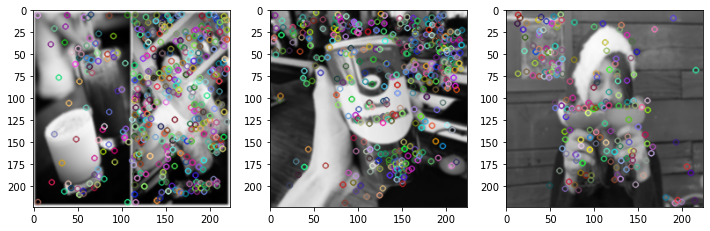

food
L'image vMYGTHdQu5ucrvKHbfm41A.jpg numéro 0 contient 412 descripteurs
L'image mIWnRyCU9sCjFwimaYLAEg.jpg numéro 1 contient 122 descripteurs
L'image Uw5S1WaaWUOxG8Ujr2A3cA.jpg numéro 2 contient 354 descripteurs


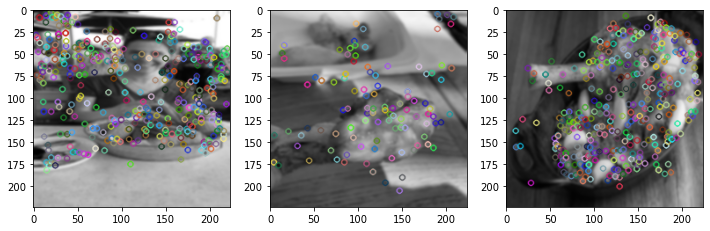

inside
L'image J469v_lnZosvyrD8lpNgmQ.jpg numéro 0 contient 609 descripteurs
L'image cI0s7uRWtEqMjqUsyHK4Iw.jpg numéro 1 contient 339 descripteurs
L'image ZaUKMF-g4vqcSAEnYhThyw.jpg numéro 2 contient 367 descripteurs


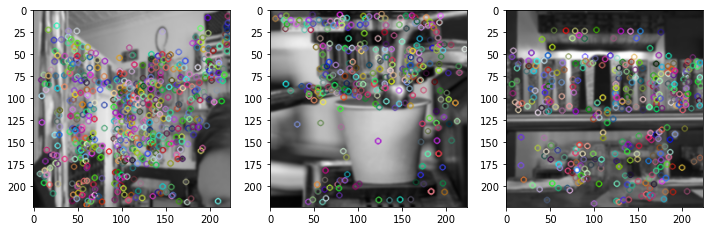

menu
L'image aTRVmYhyXrzgGmB-5R9pgQ.jpg numéro 0 contient 348 descripteurs
L'image vxeaqdpLIWBX1IouYfBg4g.jpg numéro 1 contient 561 descripteurs
L'image nzdv9ymXJNuSCZq0CrvCnw.jpg numéro 2 contient 411 descripteurs


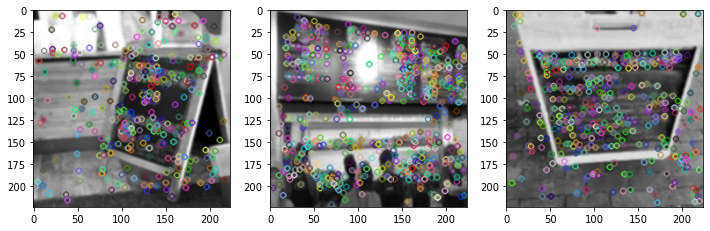

outside
L'image OVNXGzgOP4TU0wgcQBGkDg.jpg numéro 0 contient 324 descripteurs
L'image EpvDgv3n81n9tgUyK-ZM3g.jpg numéro 1 contient 235 descripteurs
L'image y_26Pw8S-Sbs9pYTtTTRow.jpg numéro 2 contient 265 descripteurs


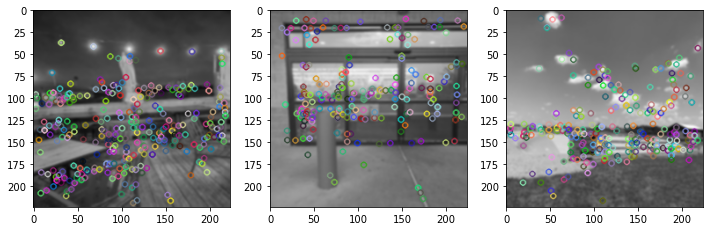

In [28]:
path = (path_photos+'/')
colors = 'BlackandWhite' #Other options = 'BlackandWhite', HSV
resize = True #False
equalize = 'Clahe' #Other options: 'Hist', 'Clahe'
blur = 'Gaussian' #Other options: None, 'Normal' ou 'Gaussian'
ksize = (5, 5) # ksize
sift = cv2.xfeatures2d.SIFT_create() #Nombre de descripteur attendu libre

for name in list_labels :
    plt.figure(figsize=(12, 5))
    plt.subplots_adjust(hspace=0.5)
    print(name)
    # print("-------")
    for i in range(3):
        #plt.subplot(4, 3, i)
        plt.subplot(130 + i + 1)
        filename = path + list_fct(weighted_images_df, name)[i+10]
        #preprocess Image: Open, Grayscale, (Resize), (Equalize), Blur in option
        image = preprocess(filename, colors, resize, equalize, blur, ksize)
        #sift = cv2.xfeatures2d.SIFT_create()
        kp, des = sift.detectAndCompute(image, None)
        img=cv2.drawKeypoints(image,kp,image)
        plt.imshow(img)
        print(f"L'image {list_fct(weighted_images_df, name)[i+10]} numéro {i} contient {des.shape[0]} descripteurs")
        
    plt.show()

In [29]:
# identification of key points and associated descriptors
sift_keypoints = []
temps1=time.time()

range_study = n_sample #len(photos_name)
sift = cv2.xfeatures2d.SIFT_create(500) #Nombre de descripteurs prédéfinis à 500
#sift = cv2.SIFT_create(contrastThreshold=0.03) 

path = (path_photos+'/')
colors = 'BlackandWhite' #Other options = 'BlackandWhite', HSV
resize = False #False True
equalize = None #Other options: 'Hist', 'Clahe', None
blur = 'Gaussian' #Other options: None, 'Normal' ou 'Gaussian'
ksize = (5, 5) # ksize

for name in list_labels : #We run the descripteur SIFT on 100 picture, of each of the 5 label sequentially.
    #print(name)
    # print("-------")
    for image_num in range(range_study):
        if image_num%100 == 0 : print(image_num)
        #filename = path + list_fct(name)[image_num]
        filename = path + list_fct(weighted_images_df, name)[image_num]
        #preprocess Image: Open, Grayscale, (Resize), (Equalize), Blur in option
        image = preprocess(filename, colors, resize, equalize, blur, ksize) #preprocess(filename, blur, ksize)
        
        kp, des = sift.detectAndCompute(image, None)
        sift_keypoints.append(des)
        #weighted_images_df.loc[(weighted_images_df['image_full_name'] == list_fct(weighted_images_df, name)[image_num]),'sift_keypoints_by_img'] = np.asarray(des) #np.asarray(sift_keypoints) #sift_keypoints
        

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900

Nombre de descripteurs :  (2255577, 128)
temps de traitement SIFT descriptor :           372.92 secondes


In [30]:
weighted_images_df.insert(len(weighted_images_df.columns),'sift_keypoints',sift_keypoints_by_img)
weighted_images_df

photo_id             business_id  \
0     sMc1HR7VqN701rPNJ45gFQ  9qXZSFq9vPdX4F6kGjXC-g   
1     AAIT9XhHeYaQzGxrulTgCA  vaCZdS9Q9wIHw-YwHoYErA   
2     DtChivzQ_Q-jerMe-IPRLg  U4hibwdvk2pACJeo6FaoIA   
3     lxhwyhUj7mIFggOCMTb9qg  NKplFLr1UebQxMLQAxALPQ   
4     WCOgPOvKZl46Y1itp7HbBw  T2NZEKXgfTIPothJrLyz2A   
...                      ...                     ...   
4995  KISm_mcT6qHDZd9nhGKzwQ  eWmcdBJPPQ_iSaNU8uIpFQ   
4996  hYv3AeA_gv0duRj0azLnDg  RnURR_OfKGejCsEshpS0ww   
4997  UyA9Y00P3VwCvn94CwIhHQ  _nSL2u-ZzX6kkAF2D2EZgQ   
4998  3ZagCnoYDHyhwZaPtu3FNw  fNEQqFCwj9cLw-kqLyHuHQ   
4999  841fkMKuWX750P0VYpXqFg  U3grYFIeu6RgAAQgdriHww   

                                                caption    label  \
0     Dragon Blood | Asian inspired Craft Cocktail w...    drink   
1                                     SandBar Nashville    drink   
2                                                          drink   
3                                           Mango Lassi    drink   
4                                                          drink   
...                                                 ...      ...   
4995                             From the killer patio.  outside   
4996                                                     outside   
4997                                                     outside   
4998                                                     outside   
4999                                                     outside   

                 image_full_name              image_name image_ext   size  \
0     sMc1HR7VqN701rPNJ45gFQ.jpg  sMc1HR7VqN701rPNJ45gFQ      .jpg  23285   
1     AAIT9XhHeYaQzGxrulTgCA.jpg  AAIT9XhHeYaQzGxrulTgCA      .jpg  19080   
2     DtChivzQ_Q-jerMe-IPRLg.jpg  DtChivzQ_Q-jerMe-IPRLg      .jpg  12698   
3     lxhwyhUj7mIFggOCMTb9qg.jpg  lxhwyhUj7mIFggOCMTb9qg      .jpg  28057   
4     WCOgPOvKZl46Y1itp7HbBw.jpg  WCOgPOvKZl46Y1itp7HbBw      .jpg  66185   
...                          ...                     ...       ...    ...   
4995  KISm_mcT6qHDZd9nhGKzwQ.jpg  KISm_mcT6qHDZd9nhGKzwQ      .jpg  13076   
4996  hYv3AeA_gv0duRj0azLnDg.jpg  hYv3AeA_gv0duRj0azLnDg      .jpg  38972   
4997  UyA9Y00P3VwCvn94CwIhHQ.jpg  UyA9Y00P3VwCvn94CwIhHQ      .jpg  47765   
4998  3ZagCnoYDHyhwZaPtu3FNw.jpg  3ZagCnoYDHyhwZaPtu3FNw      .jpg  35456   
4999  841fkMKuWX750P0VYpXqFg.jpg  841fkMKuWX750P0VYpXqFg      .jpg  34942   

                                                   path  label_encoded  \
0     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
1     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
2     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
3     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
4     C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
...                                                 ...            ...   
4995  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   
4996  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   
4997  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   
4998  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   
4999  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              4   

                                         sift_keypoints  
0     [[5.0, 5.0, 1.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0,...  
1     [[54.0, 3.0, 0.0, 0.0, 32.0, 72.0, 14.0, 18.0,...  
2     [[23.0, 109.0, 46.0, 14.0, 16.0, 6.0, 2.0, 1.0...  
3     [[35.0, 4.0, 0.0, 0.0, 9.0, 8.0, 1.0, 5.0, 114...  
4     [[35.0, 37.0, 7.0, 12.0, 58.0, 7.0, 0.0, 5.0, ...  
...                                                 ...  
4995  [[7.0, 5.0, 0.0, 4.0, 115.0, 92.0, 26.0, 0.0, ...  
4996  [[21.0, 33.0, 31.0, 34.0, 16.0, 2.0, 1.0, 4.0,...  
4997  [[1.0, 1.0, 6.0, 17.0, 25.0, 13.0, 12.0, 6.0, ...  
4998  [[25.0, 25.0, 13.0, 2.0, 1.0, 28.0, 44.0, 12.0...  
4999  [[21.0, 131.0, 51.0, 0.0, 1.0, 1.0, 2.0, 3.0, ...  

[5000 rows x 11 col

## Création des clusters de descripteurs

Nous allons maintenant constituer nos **[Bags of Visual Words](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5072281-utilisez-ces-features-pour-classifier-des-images#/id/r-5108767)**. C'est à dire que l'on va créer un catalogue de "mots visuels" qui décrivent les images en réalisant un clustering sur les features / descripteurs que l'on vient d'extraire, par l'utilisation d'une **[segmentation kMeans](https://openclassrooms.com/fr/courses/4379436-explorez-vos-donnees-avec-des-algorithmes-non-supervises/4379566-partitionnez-vos-donnees-avec-l-algorithme-du-k-means#/id/r-4450317)** (MiniBatchKMeans).

Cette segmentation **utilisera les descripteurs** précedemment identifiés, et nous permettra de **réduire le nombre de dimension**. 
Ensuite on va compter le nombre d'occurence de chaques classes (= le Bag of Visual Words), equivalent à "l'empreinte digitale" de chaques images.

#### Clustering KMeans
Nous allons tenter de determiner le nombre optimal de clusters kMeans, par la [methode du coude](https://en.wikipedia.org/wiki/Elbow_method_(clustering)): 

_Note: A regarder par la suite si le score silhouette peut etre appliqué ici._

Ensuite, nous procederons à la segmentation kMeans.

In [68]:
#Determination du nombre de clusters

Sum_of_squared_distances = []
#on fixe la plage de valeur que peut prendre k, le nombre de clusters
num_clusters = [70,140,210,350,450,550,700] #range(1,10) 
#num_clusters = np.logspace(start=1, stop=7, base=2, num=10, dtype=int)


#on effectue la kmeans pour chaque valeurs de k, en prennant soin de fixer un random_state
for k in num_clusters : 
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
    #print('start_fit:',k)
    kmeans.fit(sift_keypoints_all)
    #print('end_fit',k)
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.figure(figsize=(12,8))
plt.plot(num_clusters,Sum_of_squared_distances,'bx-', color='g')
plt.xlabel('Number of Clusters') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

KeyboardInterrupt: 

Nous visualison un coude proche des 30 clusters. Nous opterons donc pour cette valeur.

In [32]:
n_clusters = 210

kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
#print('start_fit:',k)
kmeans.fit(sift_keypoints_all)

MiniBatchKMeans(n_clusters=210, random_state=0)

### Prédiction kMeans clusters et Histogramme des descripteur par image
Pour chaque image, nous allons appliquer la segmentation kMeans aux descripteurs, afin de créer le Bag of Visual words correspondant aux centres des clusters trouvés: 
* Segmentation kMeans de chaque descripteur associé à chaque image
* Création d'un [histogramme](https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5072281-utilisez-ces-features-pour-classifier-des-images#/id/r-5109001) pour chaque image = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Finalement, le bag-of-visual word d'une image est le vecteur dans lequel on a stocké les valeurs de l'histogramme que l'on a normalisé (en divisant par la norme euclidienne). 

In [33]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [34]:
# Creation of histograms (features)
temps1=time.time()

# Creation of a matrix of histograms
hist_vectors=[]

for image_num, image_desc in enumerate(sift_keypoints_by_img):
    if image_num%100 == 0 : print(image_num)
    hist = build_histogram(kmeans, image_desc, image_num) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features_by_img = np.asarray(hist_vectors)
#im_features_all = np.concatenate(im_features_by_img, axis=0)


duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
temps de création histogrammes :           139.16 secondes


In [35]:
#kmean.predict sur les descripteurs de chaques images
weighted_images_df['predBoW'] = weighted_images_df['sift_keypoints'].apply(lambda x: kmeans.predict(x))
weighted_images_df.head(3)

photo_id             business_id  \
0  sMc1HR7VqN701rPNJ45gFQ  9qXZSFq9vPdX4F6kGjXC-g   
1  AAIT9XhHeYaQzGxrulTgCA  vaCZdS9Q9wIHw-YwHoYErA   
2  DtChivzQ_Q-jerMe-IPRLg  U4hibwdvk2pACJeo6FaoIA   

                                             caption  label  \
0  Dragon Blood | Asian inspired Craft Cocktail w...  drink   
1                                  SandBar Nashville  drink   
2                                                     drink   

              image_full_name              image_name image_ext   size  \
0  sMc1HR7VqN701rPNJ45gFQ.jpg  sMc1HR7VqN701rPNJ45gFQ      .jpg  23285   
1  AAIT9XhHeYaQzGxrulTgCA.jpg  AAIT9XhHeYaQzGxrulTgCA      .jpg  19080   
2  DtChivzQ_Q-jerMe-IPRLg.jpg  DtChivzQ_Q-jerMe-IPRLg      .jpg  12698   

                                                path  label_encoded  \
0  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
1  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   
2  C:/Users/blanc/OpenClassrooms/IA_Project6_Open...              0   

                                      sift_keypoints  \
0  [[5.0, 5.0, 1.0, 0.0, 0.0, 0.0, 1.0, 4.0, 1.0,...   
1  [[54.0, 3.0, 0.0, 0.0, 32.0, 72.0, 14.0, 18.0,...   
2  [[23.0, 109.0, 46.0, 14.0, 16.0, 6.0, 2.0, 1.0...   

                                             predBoW  
0  [17, 13, 151, 206, 190, 17, 188, 30, 150, 40, ...  
1  [166, 0, 89, 0, 110, 114, 1, 176, 114, 149, 37...  
2  [23, 90, 50, 35, 140, 95, 207, 40, 50, 23, 130...

In [36]:
dic_sift = {}
clust = np.unique(kmeans.labels_) #Correspons to array from 0 to n_clusters - 1

for i in range(len(clust)):
    dic_sift[i]=0
print(f"clust array is {clust}")
print(f"dic_sift array is {dic_sift}")


clust array is [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209]
dic_sift array is {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 

In [37]:
#range(len(Counter(weighted_images_df['predBoW'][1])))

#fonction qui renvoie le Bag of Images pour une image
def imBow(dicoDes):
    dct={}
    colec = Counter(dicoDes)
    for i in range(len(clust)):   #range(len(colec)):
        dct[i]=colec[i]
        #dct[i]=Counter(dic_sift)
        #dct[i].update(Counter[i])     
    return dct

weighted_images_df['countBoW'] = weighted_images_df['predBoW'].apply(lambda x: imBow(x))

In [38]:
collections.Counter(weighted_images_df['predBoW'][1])
# == weighted_images_df['countBoW'][1]

Counter({166: 3,
         0: 3,
         89: 1,
         110: 4,
         114: 11,
         1: 7,
         176: 1,
         149: 2,
         37: 2,
         159: 4,
         175: 3,
         135: 1,
         27: 2,
         143: 4,
         198: 3,
         9: 1,
         152: 4,
         104: 2,
         24: 1,
         185: 5,
         145: 2,
         48: 5,
         146: 3,
         43: 4,
         36: 3,
         64: 2,
         91: 1,
         158: 1,
         63: 1,
         123: 3,
         190: 1,
         106: 1,
         153: 7,
         23: 5,
         191: 2,
         139: 2,
         174: 1,
         35: 13,
         119: 4,
         93: 2,
         205: 1,
         189: 1,
         144: 1,
         111: 2,
         45: 2,
         79: 1,
         156: 1,
         80: 2,
         44: 3,
         6: 1,
         201: 1,
         33: 1,
         13: 9,
         122: 1,
         154: 3,
         183: 2,
         178: 4,
         78: 2,
         193: 1,
         203: 2,
      

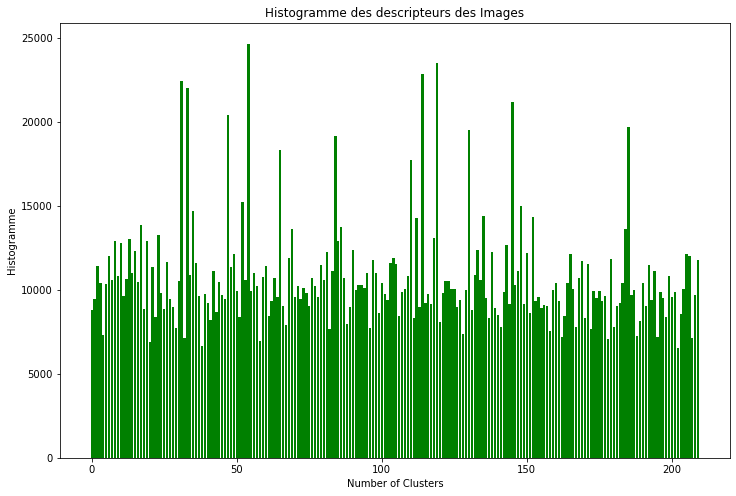

In [39]:
#création de l'histogramme de toute les images
for im in range(len(weighted_images_df)):
    for des in weighted_images_df['countBoW'][im]:
        dic_sift[des]=dic_sift[des]+weighted_images_df['countBoW'][im][des]
dic_sift

plt.figure(figsize=(12,8))
plt.bar(dic_sift.keys(), dic_sift.values(),color='g')

plt.xlabel('Number of Clusters') 
plt.ylabel('Histogramme') 
plt.title('Histogramme des descripteurs des Images')

plt.show()

 ## Création des Bag of Visual Words

In [40]:

df_bow_sift = pd.DataFrame.from_dict(weighted_images_df['countBoW'][0], orient='index')
for i in range(1,len(weighted_images_df)):
    new = pd.DataFrame.from_dict(weighted_images_df['countBoW'][i], orient='index')
    df_bow_sift.insert(i, str(i),new)
df_bow_sift = df_bow_sift.T
df_bow_sift

0    1    2    3    4    5    6    7    8    9    ...  200  201  202  \
0       1    0    1    3    0    7    0    4    0    0  ...    2    3    0   
1       3    7    0    0    1    0    1    0    1    1  ...    0    1    0   
2       0    0    0    0    0    0    0    0    2    0  ...    0    1    2   
3       1    3    5    0    1    1    5    2    4    5  ...    0    5    2   
4       1    3   11    1    5    1    2    3   12    3  ...    3    2    0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4995    2    1    3    3    1    2    0    2    0    0  ...    3    1    0   
4996    0    5    5    3    3    2    4    1    4    3  ...    0    2    1   
4997    0    0    0    2    1    3    1    2    7    2  ...    0    0    0   
4998    1    0    1    2    0    2    4    5    4    0  ...    1    5    2   
4999    5    1    2    2    2    5    1    1    1    3  ...    3    3    0   

      203  204  205  206  207  208  209  
0       1    3    6    3    1    3    1  
1       2    1    1    1    0    1    1  
2       0    0    0    0    2    0    0  
3       1    3    3    1    3    3    0  
4       2    2    2    0    2    6    1  
...   ...  ...  ...  ...  ...  ...  ...  
4995    2    0    4    0    2    0    0  
4996    0    0    2    1    1    1    3  
4997    1    0    5    4    2    0    3  
4998    0    1    2    2    0    2    2  
4999    3    1    5    4    1    3    4  

[5000 rows x 210 columns]

## Classification des photos
Nous allons maintenant entrainer un CLassifier, dans le but de pouvoir prédire le label des photos.

Pour se faire, nous allons préparer nos données pour les étapes de classification:
- Normalisation des données (`StandardScaler`)
- Non réalisé ici!!! Remplissage des valeurs manquantes ? (`SimpleImputer`)
- Réduction des dimensions (`PCA`)
- Visualisation (`T-SNE`)

In [41]:
#Remplissage des données manquantes par la valeur médiane .
#imputer = SimpleImputer(strategy='median')
#df_bow_sift_median=imputer.fit_transform(df_bow_sift)
#df_bow_sift_median=pd.DataFrame(sift_bow)
#df_bow_sift_median

In [82]:
df_bow_sift.head()

0    1    2    3    4    5    6    7    8    9    ...  200  201  202  203  \
0    1    0    1    3    0    7    0    4    0    0  ...    2    3    0    1   
1    3    7    0    0    1    0    1    0    1    1  ...    0    1    0    2   
2    0    0    0    0    0    0    0    0    2    0  ...    0    1    2    0   
3    1    3    5    0    1    1    5    2    4    5  ...    0    5    2    1   
4    1    3   11    1    5    1    2    3   12    3  ...    3    2    0    2   

   204  205  206  207  208  209  
0    3    6    3    1    3    1  
1    1    1    1    0    1    1  
2    0    0    0    2    0    0  
3    3    3    1    3    3    0  
4    2    2    0    2    6    1  

[5 rows x 210 columns]

In [42]:
# Centrage et réduction
std_scale = StandardScaler().fit(df_bow_sift) #ou df_bow_sift_median
df_bow_sift_scaled = std_scale.transform(df_bow_sift)
df_bow_sift_scaled=pd.DataFrame(df_bow_sift_scaled)
df_bow_sift_scaled.head()

0         1         2         3         4         5         6    \
0 -0.455755 -0.943150 -0.543500  0.489396 -0.737557  2.446327 -1.044779   
1  0.734206  2.541148 -0.967182 -1.113079 -0.235202 -1.026878 -0.609781   
2 -1.050736 -0.943150 -0.967182 -1.113079 -0.737557 -1.026878 -1.044779   
3 -0.455755  0.550121  1.151229 -1.113079 -0.235202 -0.530706  1.130212   
4 -0.455755  0.550121  3.693323 -0.578920  1.774216 -0.530706 -0.174782   

        7         8         9    ...       200       201       202       203  \
0  0.765870 -0.922715 -0.958753  ...  0.040160  0.570184 -0.222348 -0.316076   
1 -0.863988 -0.565931 -0.516646  ... -0.951442 -0.543675 -0.222348  0.129855   
2 -0.863988 -0.209147 -0.958753  ... -0.951442 -0.543675  0.118258 -0.762007   
3 -0.049059  0.504422  1.251782  ... -0.951442  1.684043  0.118258 -0.316076   
4  0.358406  3.358695  0.367568  ...  0.535961  0.013255 -0.222348  0.129855   

        204       205       206       207       208       209  
0  0.469856  1.707314  0.248441 -0.304524  0.599059 -0.599635  
1 -0.478008 -0.678536 -0.582188 -1.024781 -0.528900 -0.599635  
2 -0.951940 -1.155705 -0.997503  0.415732 -1.092880 -1.040349  
3  0.469856  0.275804 -0.582188  1.135988  0.599059 -1.040349  
4 -0.004076 -0.201366 -0.997503  0.415732  2.290998 -0.599635  

[5 rows x 210 columns]

### Visualisation T-SNE

In [43]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=0)
X_tsne = tsne.fit_transform(df_bow_sift_scaled)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["label"] = weighted_images_df['label']
df_tsne.head()

tsne1      tsne2  label
0 -10.984159  48.014267  drink
1 -30.455044 -24.268724  drink
2 -35.224941 -25.503281  drink
3  11.010789 -36.956051  drink
4 -14.047085 -46.736973  drink

In [64]:
df_bow_sift_scaled.shape

(5000, 210)

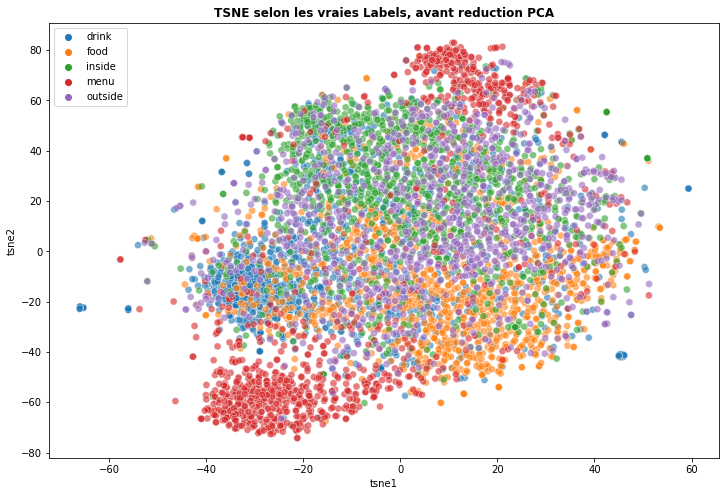

In [44]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,
sns.scatterplot(
    x="tsne1", y="tsne2", hue="label", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les vraies Labels, avant reduction PCA', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

Il ne se dégage pas particulièrement de zones dans lesquels se regroupe distinctivement des catégories spécifiques.

On va donc maintenant réaliser une réduction de dimension sur nos Bag of Visual Words. On espère pourvoir mieux discriminer les catégories différentes et rassembler ceux de même catégories, en diminuant le bruit. 

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (9%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [71]:
# Calcul des composantes principales - SIFT
print("Dimensions dataset avant réduction PCA : ", df_bow_sift_scaled.shape)
pca_sift = decomposition.PCA()
feat_pca_sift = pca_sift.fit_transform(df_bow_sift_scaled)
print("Dimensions dataset après réduction PCA : ", feat_pca_sift.shape)

Dimensions dataset avant réduction PCA :  (5000, 210)
Dimensions dataset après réduction PCA :  (5000, 210)


In [72]:
#nombre de composantes calculées
n_comp_sift=pca_sift.n_components_
n_comp_sift

210

In [47]:
#variance expliquée / eigen values
eigval_sift=pca_sift.explained_variance_
#print(pd.DataFrame(eigval_sift))
#calcul de la somme des eigen values (doit être égale à n_comp_sift) 
print(sum(eigval_sift))

210.04200840168065


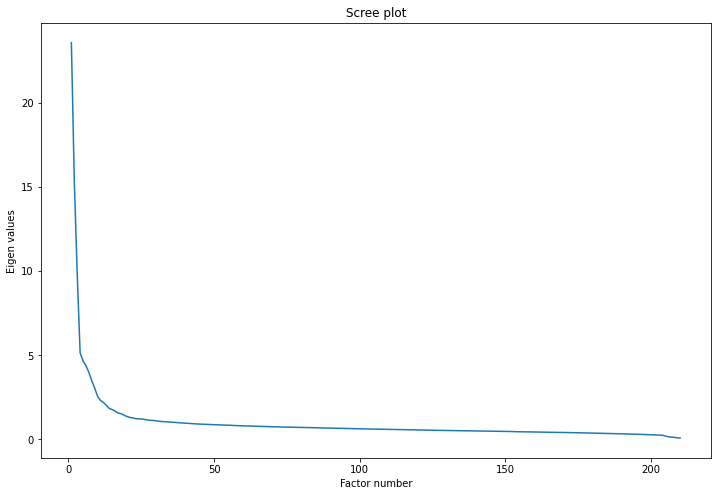

In [48]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#scree plot
plt.plot(np.arange(1,n_comp_sift+1),eigval_sift)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
#plt.xlim(0, 10)
plt.show()

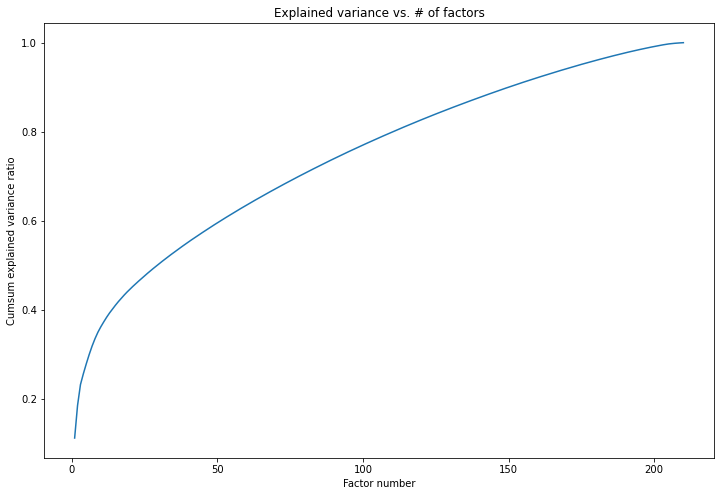

In [73]:
#proportion de variance expliquée
prop_eigval_sift=pca_sift.explained_variance_ratio_
#pd.DataFrame(prop_eigval_sift.cumsum())
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#cumul de variance expliquée
plt.plot(np.arange(1,n_comp_sift+1),np.cumsum(prop_eigval_sift))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
#plt.xlim(0, 10)
plt.show()

In [76]:
explained_variance = pd.DataFrame(prop_eigval_sift.cumsum()).iloc[150]
print(f'Explained variance after dimension reduction to 150 is = {round(explained_variance[0],4)}')

Explained variance after dimension reduction to 150 is = 0.9024


Avec 150 dimensions conservées sur 210, on conserve plus de 90% de l'information. <br>
On va maintenant réaliser la réduction de dimension :

In [51]:
# Calcul des composantes principales
pca_sift = decomposition.PCA(150)
df_bow_sift_reduit = pd.DataFrame(pca_sift.fit_transform(df_bow_sift))
df_bow_sift_reduit

0          1          2          3          4         5    \
0    -16.445013   4.471216  10.243285   9.471056  -3.016414 -0.555758   
1      3.666059  -7.652392   0.928861  -5.294754  -7.852008  0.865607   
2     -3.035056  -7.948004   2.246495  -4.607044  -2.627480  4.196435   
3      3.621430 -10.973942  -7.148104  -4.217494  11.048136  0.212237   
4      6.488164  -0.320764  -1.795850  -7.723689  11.756048 -2.739833   
...         ...        ...        ...        ...        ...       ...   
4995 -13.399823   2.676546   7.003859   8.291314  -5.520627  1.750876   
4996   9.698806  -7.494516 -14.227696  -2.789278  -5.326063 -5.492310   
4997  -3.237441   3.377377  -2.500883  -0.541166  -6.931954  6.021654   
4998  -7.239573  10.135639  -1.169144   2.999736   7.431396 -0.927752   
4999 -15.270238   4.170093   6.594169  15.173288  -5.150785 -2.059901   

            6         7         8         9    ...       140       141  \
0     -3.125671 -0.834359 -3.736657 -0.227042  ...  1.108084 -0.589765   
1      8.727231  5.985786 -4.155355  0.153916  ...  0.962328 -0.850189   
2     21.711866  3.675505 -5.908072  5.642651  ...  0.357059  0.125149   
3     -3.010753 -5.609733 -2.569894 -1.739992  ... -0.931090  0.530705   
4     -2.971776 -6.250002 -5.212680  8.719636  ... -0.569719 -0.694644   
...         ...       ...       ...       ...  ...       ...       ...   
4995  11.164941  0.155934 -4.037267  1.176624  ...  0.762932 -0.921636   
4996  -4.535387  3.026808  2.506009 -3.551086  ...  1.367725  1.230836   
4997  -5.411159 -0.033726  8.013778 -2.045643  ...  2.858744  1.183917   
4998  -0.272596  3.911420 -0.043215  0.495747  ...  2.529529  0.432382   
4999  -0.654519 -5.670195  1.464432 -5.166871  ...  2.528617 -1.490465   

           142       143       144       145       146       147       148  \
0     1.335136  2.321526  1.501678  1.302596 -1.552719  1.228683  1.901436   
1     0.567911  0.849418 -0.460644  0.547813  0.632819  0.082667  0.309174   
2     0.375733 -0.480869  0.268142  0.165596  1.170422  0.103783  0.272921   
3    -2.484211  0.086441 -2.616127  3.914335 -0.824722 -0.384215  1.831187   
4    -4.577796  0.475823 -2.107654  0.127638 -2.150684 -2.283982 -0.195529   
...        ...       ...       ...       ...       ...       ...       ...   
4995  1.193695 -0.630723 -0.014739  1.100208 -0.256642  0.734996  0.601249   
4996  1.477096 -1.558841  2.226416 -0.561684 -0.333189  1.660346 -1.081971   
4997  0.484162  0.536623  0.367344 -1.978079 -3.530637  1.360455 -0.249829   
4998  0.112810 -0.870273  3.314331  2.098542 -0.548993  1.108059  0.247690   
4999 -0.047897  1.543608  1.733631  3.276222 -0.923007 -0.559308 -1.086000   

           149  
0     0.965053  
1     0.615717  
2     0.179524  
3     1.315136  
4    -0.968088  
...        ...  
4995 -1.380800  
4996 -2.011056  
4997  0.263500  
4998  0.515817  
4999  0.313510  

[5000 rows x 150 columns]

In [52]:
# Centrage et réduction
std_scale = StandardScaler().fit(df_bow_sift_reduit) #ou df_bow_sift_median
df_bow_sift_scaled_reduit = std_scale.transform(df_bow_sift_reduit)
df_bow_sift_scaled_reduit = pd.DataFrame(df_bow_sift_scaled_reduit)
df_bow_sift_scaled_reduit

0         1         2         3         4         5         6    \
0    -0.849274  0.312273  1.004429  1.035905 -0.361908 -0.070607 -0.445878   
1     0.189327 -0.534449  0.091082 -0.579118 -0.942082  0.109972  1.244942   
2    -0.156740 -0.555095  0.220285 -0.503900 -0.315244  0.533143  3.097205   
3     0.187023 -0.766428 -0.700924 -0.461292  1.325552  0.026964 -0.429485   
4     0.335070 -0.022402 -0.176096 -0.844785  1.410487 -0.348086 -0.423925   
...        ...       ...       ...       ...       ...       ...       ...   
4995 -0.692011  0.186932  0.686779  0.906870 -0.662363  0.222443  1.592682   
4996  0.500878 -0.523423 -1.395129 -0.305080 -0.639019 -0.697779 -0.646974   
4997 -0.167192  0.235879 -0.245230 -0.059191 -0.831694  0.765030 -0.771904   
4998 -0.373875  0.707881 -0.114643  0.328099  0.891617 -0.117868 -0.038886   
4999 -0.788605  0.291242  0.646606  1.659592 -0.617990 -0.261703 -0.093367   

           7         8         9    ...       140       141       142  \
0    -0.125812 -0.577099 -0.036635  ...  0.787927 -0.419787  0.952065   
1     0.902588 -0.641763  0.024836  ...  0.684284 -0.605153  0.404969   
2     0.554224 -0.912458  0.910489  ...  0.253894  0.089079  0.267930   
3    -0.845883 -0.396901 -0.280762  ... -0.662071  0.377748 -1.771452   
4    -0.942428 -0.805059  1.406986  ... -0.405111 -0.494438 -3.264354   
...        ...       ...       ...  ...       ...       ...       ...   
4995  0.023513 -0.623526  0.189858  ...  0.542499 -0.656008  0.851205   
4996  0.456408  0.387034 -0.572997  ...  0.972550  0.876093  1.053294   
4997 -0.005086  1.237668 -0.330082  ...  2.032771  0.842696  0.345248   
4998  0.589797 -0.006674  0.079993  ...  1.798676  0.307764  0.080443   
4999 -0.855000  0.226171 -0.833718  ...  1.798027 -1.060892 -0.034155   

           143       144       145       146       147       148       149  
0     1.664552  1.083396  0.942714 -1.126965  0.894199  1.392481  0.707203  
1     0.609039 -0.332335  0.396463  0.459301  0.060163  0.226418  0.451205  
2    -0.344787  0.193453  0.119845  0.849493  0.075530  0.199868  0.131558  
3     0.061979 -1.887422  2.832881 -0.598584 -0.279620  1.341035  0.963748  
4     0.341169 -1.520581  0.092374 -1.560969 -1.662214 -0.143192 -0.709427  
...        ...       ...       ...       ...       ...       ...       ...  
4995 -0.452233 -0.010633  0.796242 -0.186271  0.534908  0.440313 -1.011867  
4996 -1.117701  1.606263 -0.406502 -0.241829  1.208350 -0.792361 -1.473727  
4997  0.384763  0.265023 -1.431575 -2.562540  0.990099 -0.182957  0.193096  
4998 -0.623993  2.391146  1.518756 -0.398460  0.806412  0.181391  0.377997  
4999  1.106779  1.250739  2.371067 -0.669920 -0.407047 -0.795311  0.229744  

[5000 rows x 150 columns]

In [53]:
df_bow_sift.to_csv("./Models/df_bow_sift.csv", index = False)
df_bow_sift_scaled.to_csv("./Models/df_bow_sift_scaled.csv", index = False)

df_bow_sift_reduit.to_csv("./Models/df_bow_sift_reduit.csv", index = False)
df_bow_sift_scaled_reduit.to_csv("./Models/df_bow_sift_scaled_reduit.csv", index = False)


In [65]:
df_bow_sift_scaled_reduit.shape

(5000, 150)

In [54]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=0)
X_tsne_reduit = tsne.fit_transform(df_bow_sift_scaled_reduit)

df_tsne_reduit = pd.DataFrame(X_tsne_reduit[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_reduit["label"] = weighted_images_df['label']
df_tsne_reduit

tsne1      tsne2    label
0      3.238106  -1.216883    drink
1     -7.995947  -4.212450    drink
2      6.209633   4.244820    drink
3      8.117704   8.405108    drink
4     -1.671163  26.657795    drink
...         ...        ...      ...
4995  14.237570   7.687118  outside
4996 -12.183948 -11.641250  outside
4997  -2.718661  -6.073717  outside
4998   6.664433   5.932182  outside
4999   6.847895  -1.059618  outside

[5000 rows x 3 columns]

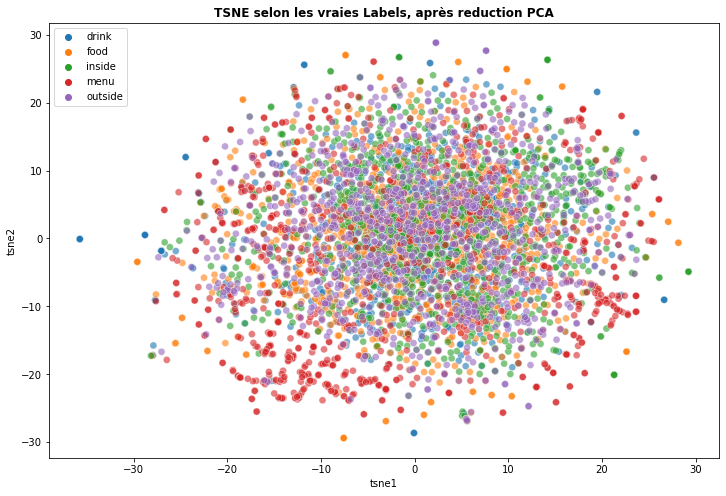

In [55]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,
sns.scatterplot(
    x="tsne1", y="tsne2", hue="label", data=df_tsne_reduit, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les vraies Labels, après reduction PCA', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

On peut voir ici que comme pour le t-SNE avant réduction de dimensions, même si on observe quelques regroupement de produit de la même catégorie. L'ensemble des produits restent malgrès tout mélangés. <br>

## Segmentation KMeans
### Comparaison des résultats de prédiction avant la reduction ACP

In [77]:
df_bow_sift_scaled.shape

(5000, 210)

In [57]:
#kmeans sur la matrice pre-ACP 
kmeans_sift = MiniBatchKMeans(n_clusters=5, random_state=0) #MiniBatchKMeans(n_clusters=7, random_state=5)
kmeans_sift.fit(df_bow_sift_scaled)
kmeans_sift.labels_

array([2, 4, 4, ..., 3, 2, 2])

In [84]:
from joblib import dump, load

#save kmeans model in joblib files
dump(kmeans_sift, './Models/kmeans_sift.joblib')

['./Models/kmeans_sift.joblib']

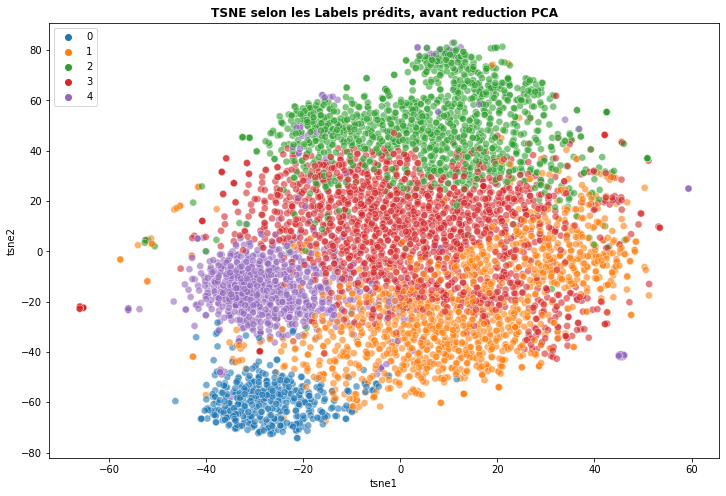

In [58]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,
sns.scatterplot(
    x=df_tsne['tsne1'], y=df_tsne['tsne2'], hue=kmeans_sift.labels_, data=kmeans_sift, legend="brief", #X_tsne_reduit
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les Labels prédits, avant reduction PCA', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

In [59]:
ARI = adjusted_rand_score(df_tsne["label"],kmeans_sift.labels_)
print(f'ARI value is {ARI}')

ARI value is 0.12333283043777442


Nous obtenons ici un ARI de 8%, ce qui n'est pas très performant.

### Comparaison des résultats de prédiction après  réduction ACP

In [78]:
df_bow_sift_scaled_reduit.shape

(5000, 150)

In [60]:
#kmeans sur la matrice post-ACP 
kmeans_sift_acp = MiniBatchKMeans(n_clusters=5, random_state=0) #MiniBatchKMeans(n_clusters=7, random_state=5)
kmeans_sift_acp.fit(df_bow_sift_scaled_reduit)
kmeans_sift_acp.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
#save kmeans model in joblib files
#dump(kmeans_sift_acp, './Models/kmeans_sift_acp.joblib')

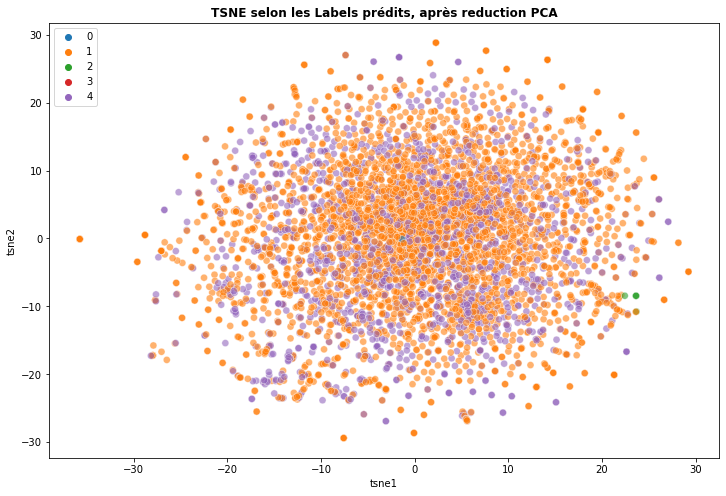

In [79]:
#Définir la taille du graphique
plt.figure(figsize=(12,8))
#Définir le type du graphique,

sns.scatterplot(
    x=df_tsne_reduit['tsne1'], y=df_tsne_reduit['tsne2'], hue=kmeans_sift_acp.labels_, data=kmeans_sift_acp, legend="brief", #X_tsne_reduit
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)
#Afficher les titres et noms des axes
plt.title('TSNE selon les Labels prédits, après reduction PCA', fontweight = 'bold')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
#Afficher la légende 
plt.legend(loc='upper left')
#Afficher le graphique
plt.show()

In [80]:
ARI = adjusted_rand_score(df_tsne_reduit["label"],kmeans_sift_acp.labels_)
print(f'ARI value is {ARI}')

ARI value is 0.0052367019730979805


La performance est encore plus faible après réduction ACP, ce qui est normal compte tenu de la récision réduite des données

Suite aux résultats décevants de l'utilisation de SIFT et kMeans pour segmenter nos photos, nous allons tester une méthode d'extraction de features à l'aide d'un réseau de neurone CNN spécialement conçus pour traiter des images en entrée. Leur architecture est alors plus spécifique : elle est composée de deux blocs principaux:
 - Le premier bloc fonctionne comme un extracteur de features. (Convolution)
 - Le second bloc transforme les valeurs du vecteur en entrée (avec plusieurs combinaisons linéaires et fonctions d'activation) pour renvoyer un nouveau vecteur en sortie


